# Scalar implicature from prosodic stress

If someone says "I _passed_ the test," you infer that they didn't _ace_ the test. This inference is stronger with the prosodic stress on "passed." The following Rational Speech Acts model recovers this inference.

The speaker has uncertainty about whether or not they merely passed or also aced. The speaker seeks to bring the listener's belief into alignment with their own, by minimizing KL divergence. The speaker can choose to apply prosodic stress, which has a cost, in order to reduce the noise with which the utterance is corrupted when received by the listener.

**Inspired by:** Bergen, L., & Goodman, N. D. (2015). The strategic use of noise in pragmatic reasoning. _Topics in cognitive science_, 7(2), 336-350.

In [1]:
from memo import memo
from enum import IntEnum
import jax.numpy as np

class Meaning(IntEnum):
    Passed = 0
    Aced = 1

class Observation(IntEnum):
    Only_Passed = 0
    At_Least_Passed = 1

class Utterance(IntEnum):
    I_Passed = 0
    I_Aced = 1

class Prosody(IntEnum):
    Unstressed = 0
    Stressed = 1

In [2]:
@memo
def O[m: Meaning, o: Observation]():
    """ Generate an observation for the speaker given a true meaning """
    world: knows(m)
    world: chooses(o in Observation, wpp=o >= m)
    return Pr[world.o == o]
O(print_table=True);

+------------+-----------------+------+
| m: Meaning | o: Observation  | O    |
+------------+-----------------+------+
| Passed     | Only_Passed     | 0.5  |
| Passed     | At_Least_Passed | 0.5  |
| Aced       | Only_Passed     | 0.0  |
| Aced       | At_Least_Passed | 1.0  |
+------------+-----------------+------+


In [3]:
def denotes(u, m):
    """
    "I Passed" is consistent with passing and acing.
    "I Aced" is only consistent with acing.
    """
    return np.array([
        [1, 1],  # Utterance = "I Passed"
        [0, 1]   # Utterance = "I Aced"
    ])[u, m]

def corrupt(u, p, u_):
    """
    Given utterance u and prosody p, output the probability
    that the listener hears u_. Here, u = u_ with probability
    70% with unstressed prosody and 99% with stressed prosody.
    """
    return np.array([
        np.where(u == u_, 0.70, 0.30), # unstressed
        np.where(u == u_, 0.99, 0.01)  # stressed
    ])[p]

def prior(m):
    """
    Prior over meanings.
    """
    return 1

In [4]:
beta = 3.0  # used in speaker's softmax
cost = 0.1  # cost of stressed prosody

@memo
def S[o: Observation, u: Utterance, p: Prosody](level):
    speaker: thinks[
        world: chooses(m in Meaning, wpp=prior(m)),
        world: chooses(o in Observation, wpp=O[m, o]())
    ]
    speaker: observes [world.o] is o
    # now speaker has a posterior belief over world.m

    speaker: chooses(u in Utterance, p in Prosody, wpp=exp(
        {beta} * (imagine[
            world: knows(u, p),
            world: chooses(u_ in Utterance, wpp=corrupt(u, p, u_)),
            listener: knows(world.u_, p),
            listener: chooses(m in Meaning, wpp=L[world.u_, p, m](level)),
            -KL[world.m | listener.m]
        ] - p * {cost})
    ))
    return Pr[speaker.u == u, speaker.p == p]

@memo
def L[u: Utterance, p: Prosody, m: Meaning](level):
    listener: thinks[
        speaker: given(m in Meaning, wpp=prior(m)),
        speaker: given(o in Observation, wpp=O[m, o]()),
        speaker: chooses(u in Utterance, p in Prosody, wpp=S[o, u, p](level - 1) if level > 0 else denotes(u, m)),
        speaker: given(u_ in Utterance, wpp=corrupt(u, p, u_))
    ]
    listener: observes [speaker.u_] is u
    listener: observes [speaker.p] is p

    listener: knows(m)
    return listener[Pr[speaker.m == m]]

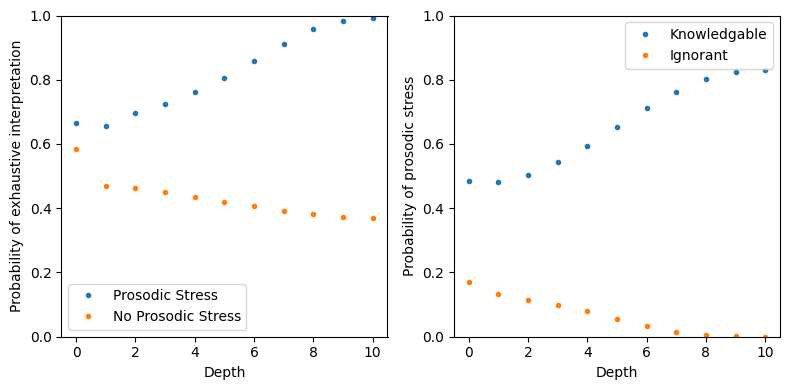

In [5]:
from matplotlib import pyplot as plt

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(
    [L(n)[Utterance.I_Passed, Prosody.Stressed, Meaning.Passed] for n in range(11)],
    '.',
    label='Prosodic Stress'
)
plt.plot(
    [L(n)[Utterance.I_Passed, Prosody.Unstressed, Meaning.Passed] for n in range(11)],
    '.',
    label='No Prosodic Stress'
)
plt.xlabel('Depth')
plt.ylabel('Probability of exhaustive interpretation')
plt.ylim(0, 1)
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(
    [S(n)[Observation.Only_Passed, Utterance.I_Passed, Prosody.Stressed] for n in range(11)],
    '.',
    label='Knowledgable'
)
plt.plot(
    [S(n)[Observation.At_Least_Passed, Utterance.I_Passed, Prosody.Stressed] for n in range(11)],
    '.',
    label='Ignorant'
)
plt.xlabel('Depth')
plt.ylabel('Probability of prosodic stress')
plt.ylim(0, 1)
plt.legend()

plt.tight_layout()